In [46]:
import pandas as pd
import codecs
import datetime
import re
from datetime import datetime 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
from bokeh.plotting import figure, output_file, show

## Read in Data

In [47]:
df = pd.read_excel('./2013-2018LargeFiresList_Redbook/CAWildlandFires_2013-Feb2020.xlsx', sheet_name='Data')

In [48]:
df.head()

,Fire Department \nIdentification Number \n(FDID),Fire Department Name,Incident \nNumber,Exposure\nNumber,NFIRS IncidentType\nCode and Description,Incident Name,Year,Start \nDate,Containment \nDate,County,...,State,Zip,Cross Streets/Directions/National Grid,Latitude,Longitude,Total \nInjuries,Total \nFatalities,Estimated \nProperty/Contents\nLoss,Total Acres \nBurned,Cause
0,33090,RIVERSIDE CFD,16,0,561 Unauthorized burning,CASTLEROCK TRL MEAD,2013,2013-01-01,2013-01-01 00:27:00,Riverside,...,CA,92570,"21540 BLK DAWES ST, 21500 BLK",33.840233,-117.286983,0,0,0,1.0,CAMPFIRE
1,33090,RIVERSIDE CFD,312,0,"142 Brush, or brush and grass mixture fire",DATE PALM,2013,2013-01-01,2013-01-01 19:03:00,Riverside,...,CA,92254,Half mile north of the Mecca C,33.964933,-116.127000,0,0,0,1.0,MISCELLANEOUS
2,30065,ORANGE COUNTY FIRE AUTHORITY,0000005,0,173 Cultivated trees or nursery stock fire,NaN,2013,2013-01-01,NaN,Orange,...,CA,000000000,NEAR BUENA VISTA ST,0.000000,0.000000,0,0,0,0.2,ARSON
3,19105,LOS ANGELES CITY FD,52,0,173 Cultivated trees or nursery stock fire,NaN,2013,2013-01-01,NaN,Los Angeles,...,CA,91342,PADDOCK ST,0.000000,0.000000,0,0,500,0.0,ARSON
4,19105,LOS ANGELES CITY FD,1384,0,173 Cultivated trees or nursery stock fire,NaN,2013,2013-01-01,NaN,Los Angeles,...,CA,90003,260 E 71ST ST X S SAN PEDRO ST,0.000000,0.000000,0,0,0,0.0,ARSON


In [49]:
df.columns

Index(['Fire Department \nIdentification Number \n(FDID)',
       'Fire Department Name', 'Incident \nNumber', 'Exposure\nNumber',
       'NFIRS IncidentType\nCode and Description', 'Incident Name', 'Year',
       'Start \nDate', 'Containment \nDate', 'County', 'Street Address',
       'City', 'State', 'Zip', 'Cross Streets/Directions/National Grid',
       'Latitude', 'Longitude', 'Total \nInjuries', 'Total \nFatalities',
       'Estimated \nProperty/Contents\nLoss', 'Total Acres \nBurned', 'Cause'],
      dtype='object')

## Data Cleaning

These column heads came in very Excel-friendly, the following cell makes them more Python/Pandas compatible. 

In [50]:
df.columns = df.columns.str.strip().str.strip(r'\\').str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('\\n','_',)
df.columns = df.columns.str.replace('__','_',).str.replace('/', '_or_')
df.columns

Index(['fire_department_identification_number_fdid', 'fire_department_name',
       'incident_number', 'exposure_number',
       'nfirs_incidenttype_code_and_description', 'incident_name', 'year',
       'start_date', 'containment_date', 'county', 'street_address', 'city',
       'state', 'zip', 'cross_streets_or_directions_or_national_grid',
       'latitude', 'longitude', 'total_injuries', 'total_fatalities',
       'estimated_property_or_contents_loss', 'total_acres_burned', 'cause'],
      dtype='object')

The next thing to deal with is all of the time-series data. Many of thes small fires that lasted less than a day had missing information or NaNs. I've replaced them with containment dates and converted all time settings to be 

In [51]:
df['containment_date'] = pd.to_datetime(df['containment_date'], errors='coerce').fillna(df['start_date'])

In [52]:
df['containment_date'].fillna(df['start_date'], inplace=True)

In [53]:
df.sort_values('start_date', inplace=True)

Most fires are unnamed, rather than have NaNs, I'm simply titling them "unnamed".

In [54]:
df['incident_name'].fillna('not_named', inplace=True)

This is a record of California Fires. Unless otherwise specified, these are California Fires. NaN and '00' values have been replaced as such. I will likely drop this column. 

In [55]:
df['state'].fillna('CA', inplace=True)
df['state'].replace('OO', 'CA', inplace=True)

Similary, if I am missing info from these string fields, I'm filling in "none_specified"

In [56]:
df['cross_streets_or_directions_or_national_grid'].fillna('none_specified', inplace=True)
df['city'].fillna('none_specified', inplace=True)
df['zip'].fillna('none_specified', inplace = True)

Some research has revealed that the largest fire in California history was the Ranch fire at 410,203 acres. I'm going to get rid of the three fires that claim to be larger than that as they have a lot of missing data surrounding them and seem to be spurious. Similarly, there shouldn't be any fires that burn negative acres. 

In [57]:
df = df.loc[df['total_acres_burned']<=410_203] 
df = df.loc[df['total_acres_burned']>=0]

fire department identification numbers are essentially the same as names, so I'm going to just drop the numbers so that the names are more explicit. 

In [58]:
type_code_values = df['nfirs_incidenttype_code_and_description'].str.findall(r'[0-9]')
type_descriptions = df['nfirs_incidenttype_code_and_description']

In [59]:
df['type_code'] = [''.join(i) for i in type_code_values]
df['type_descriptions'] = [re.sub("[0-9]", " ", i) for i in type_descriptions]

In [60]:
df.drop(columns='fire_department_identification_number_fdid', axis=1, inplace=True)
df.drop(columns='nfirs_incidenttype_code_and_description', axis = 1, inplace=True)

The most expensive fire to date in California's history was the fire that destroyed Paradise, CA which topped $12bn in damages.These numbers are clearly at the capacity of whatever data entry system was used to create them.  As these numbers run from the billions to single digits, it's possible this metric was used to describe idividual properties destroyed as well as dollar values. This is likely not going to make it into my final data set. 

In [61]:
df.loc[df['estimated_property_or_contents_loss']>12_000_000_000]

,fire_department_name,incident_number,exposure_number,incident_name,year,start_date,containment_date,county,street_address,city,...,cross_streets_or_directions_or_national_grid,latitude,longitude,total_injuries,total_fatalities,estimated_property_or_contents_loss,total_acres_burned,cause,type_code,type_descriptions


## Engineering

Creating a new cell for 'burn duration'. About 1/3 of the data set will be 0, but this may be helpful in future. 

In [79]:
df['burn_duration'] = [i.seconds/60 for i in (df['containment_date'] - df['start_date'])]

In [82]:
df['burn_duration'][1]

1143.0

In [84]:
df.burn_duration.dtype

dtype('float64')

In [85]:
df['fire_department_name'].shape

(134671,)

In [86]:
name_dummies = pd.get_dummies(df['fire_department_name'], drop_first=True)
type_dummies = pd.get_dummies(df['type_descriptions'], drop_first=True)
county_dummies = pd.get_dummies(df['county'], drop_first= True)

In [87]:
df = df.merge(name_dummies, left_index=True, right_index=True)
df = df.merge(type_dummies, left_index=True, right_index=True)
df = df.merge(county_dummies, left_index=True, right_index=True)
df.shape

(134671, 1405)

Because so many values are 0, I'm creating a dataframe that is specifically for burn duration amounts over 1 second.

In [104]:
df_duration = df.loc[df['burn_duration']> .000 ]

Creating a seperate dataframe for coordinates that are available.  

In [105]:
coords_df = df.loc[df['latitude']!=0]

In [106]:
coords_df.shape

(34453, 1405)

In [107]:
coords_df.to_csv('./coords_df', mode='w', index=False)

And another for acres

In [108]:
df_acres = df.loc[df['total_acres_burned']>0]
df_acres.to_csv('./df_acres', mode='w', index=False)

In [109]:
df_duration.burn_duration.describe()

count    45605.000000
mean       863.872636
std        335.908690
min          0.016667
25%        693.000000
50%        912.000000
75%       1101.000000
max       1439.933333
Name: burn_duration, dtype: float64

In [110]:
df['total_acres_burned'].value_counts(normalize = True)

0.00        0.333910
0.01        0.184509
0.10        0.124058
1.00        0.078436
0.25        0.043952
              ...   
3889.00     0.000007
4.55        0.000007
62.50       0.000007
265.00      0.000007
31359.00    0.000007
Name: total_acres_burned, Length: 1470, dtype: float64

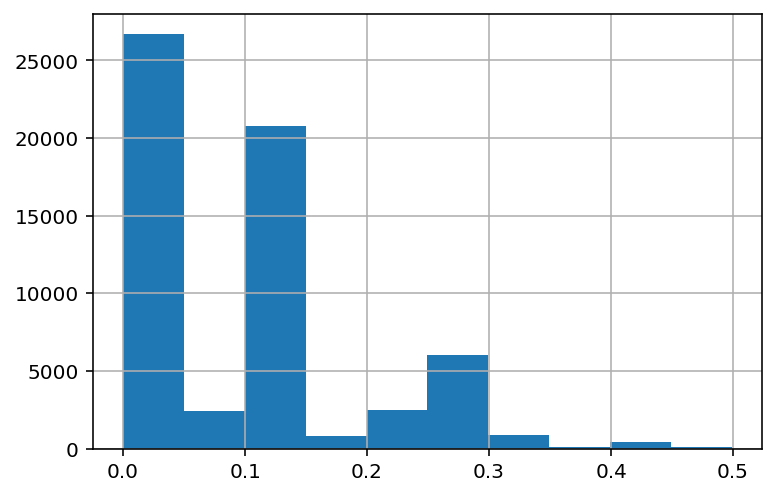

In [111]:
df[(df['total_acres_burned']<.5) &(df['total_acres_burned']>0)]['total_acres_burned'].hist();

In [112]:
df['exposure_number'].value_counts()

0     133631
1        610
2        128
3         62
4         41
       ...  
56         1
57         1
58         1
59         1
41         1
Name: exposure_number, Length: 83, dtype: int64

In [113]:
# plt.figure(figsize=(15, 10))
# sns.heatmap(df.corr(), annot=True);

In [114]:
coords_df.shape

(34453, 1405)

In [115]:
df_duration.shape

(45605, 1405)

In [116]:
df_duration.head(1)

,fire_department_name,incident_number,exposure_number,incident_name,year,start_date,containment_date,county,street_address,city,...,Sonoma_y,Stanislaus_y,Sutter_y,Tehama_y,Trinity_y,Tulare_y,Tuolumne_y,Ventura_y,Yolo_y,Yuba_y
0,RIVERSIDE CFD,16,0,CASTLEROCK TRL MEAD,2013,2013-01-01,2013-01-01 00:27:00,Riverside,00019275 CASTLEROCK TRL,MEAD,...,0,0,0,0,0,0,0,0,0,0


In [103]:
df.loc[df['total_acres_burned']>0].shape#['total_acres_burned'].hist();

(89703, 1405)

In [ ]:
coords_df.loc[coords_df['total_acres_burned']>0].shape

In [ ]:
plt.plot(df.loc[df['total_acres_burned']>0]['total_acres_burned'], type=)

In [ ]:
sns.distplot(df.loc[df['total_acres_burned']>100000]['total_acres_burned']);

In [ ]:
df.loc[df['total_acres_burned']>1000]['total_acres_burned'].value_counts()

In [153]:
df.head()

,fire_department_identification_number_fdid,fire_department_name,incident_number,exposure_number,nfirs_incidenttype_code_and_description,incident_name,year,start_date,containment_date,county,...,zip,cross_streets/directions/national_grid,latitude,longitude,total_injuries,total_fatalities,estimated_property/contents_loss,total_acres_burned,cause,burn_duration
0,33090,RIVERSIDE CFD,16,0,561 Unauthorized burning,CASTLEROCK TRL MEAD,2013,2013-01-01,2013-01-01 00:27:00,Riverside,...,92570,"21540 BLK DAWES ST, 21500 BLK",33.840233,-117.286983,0,0,0,1.0,CAMPFIRE,00:27:00
6,42015,LOMPOC FD,0000002,0,"142 Brush, or brush and grass mixture fire",not_named,2013,2013-01-01,2013-01-01 00:00:00,Santa Barbara,...,93436,NaN,0.000000,0.000000,0,0,0,0.0,MISCELLANEOUS,00:00:00
9,42015,LOMPOC FD,0000006,0,"142 Brush, or brush and grass mixture fire",not_named,2013,2013-01-01,2013-01-01 00:00:00,Santa Barbara,...,93436,NaN,0.000000,0.000000,0,0,0,0.0,MISCELLANEOUS,00:00:00
8,42015,LOMPOC FD,0000004,0,"142 Brush, or brush and grass mixture fire",not_named,2013,2013-01-01,2013-01-01 00:00:00,Santa Barbara,...,93436,NaN,0.000000,0.000000,0,0,0,0.0,MISCELLANEOUS,00:00:00
7,42015,LOMPOC FD,0000003,0,"142 Brush, or brush and grass mixture fire",not_named,2013,2013-01-01,2013-01-01 00:00:00,Santa Barbara,...,93436,NaN,0.000000,0.000000,0,0,0,0.0,MISCELLANEOUS,00:00:00


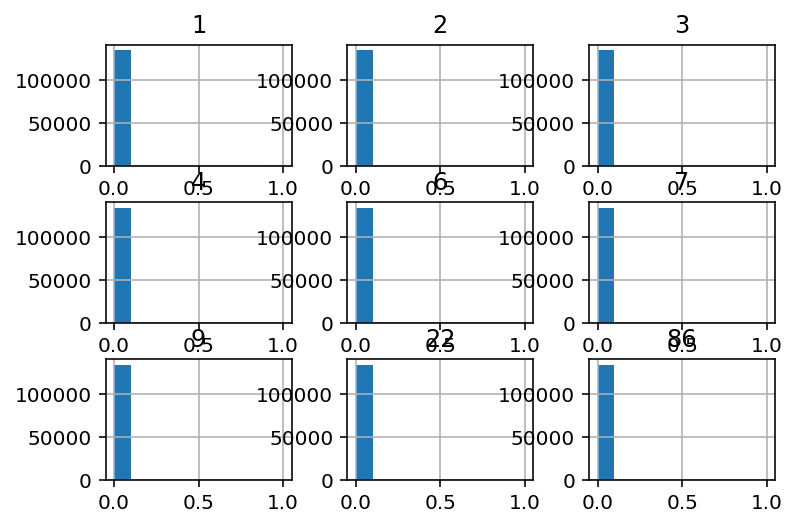

In [42]:
# pd.get_dummies(df['total_fatalities'], drop_first=True).hist();

In [191]:
df['nfirs_incidenttype_code_and_description'].nunique()

10

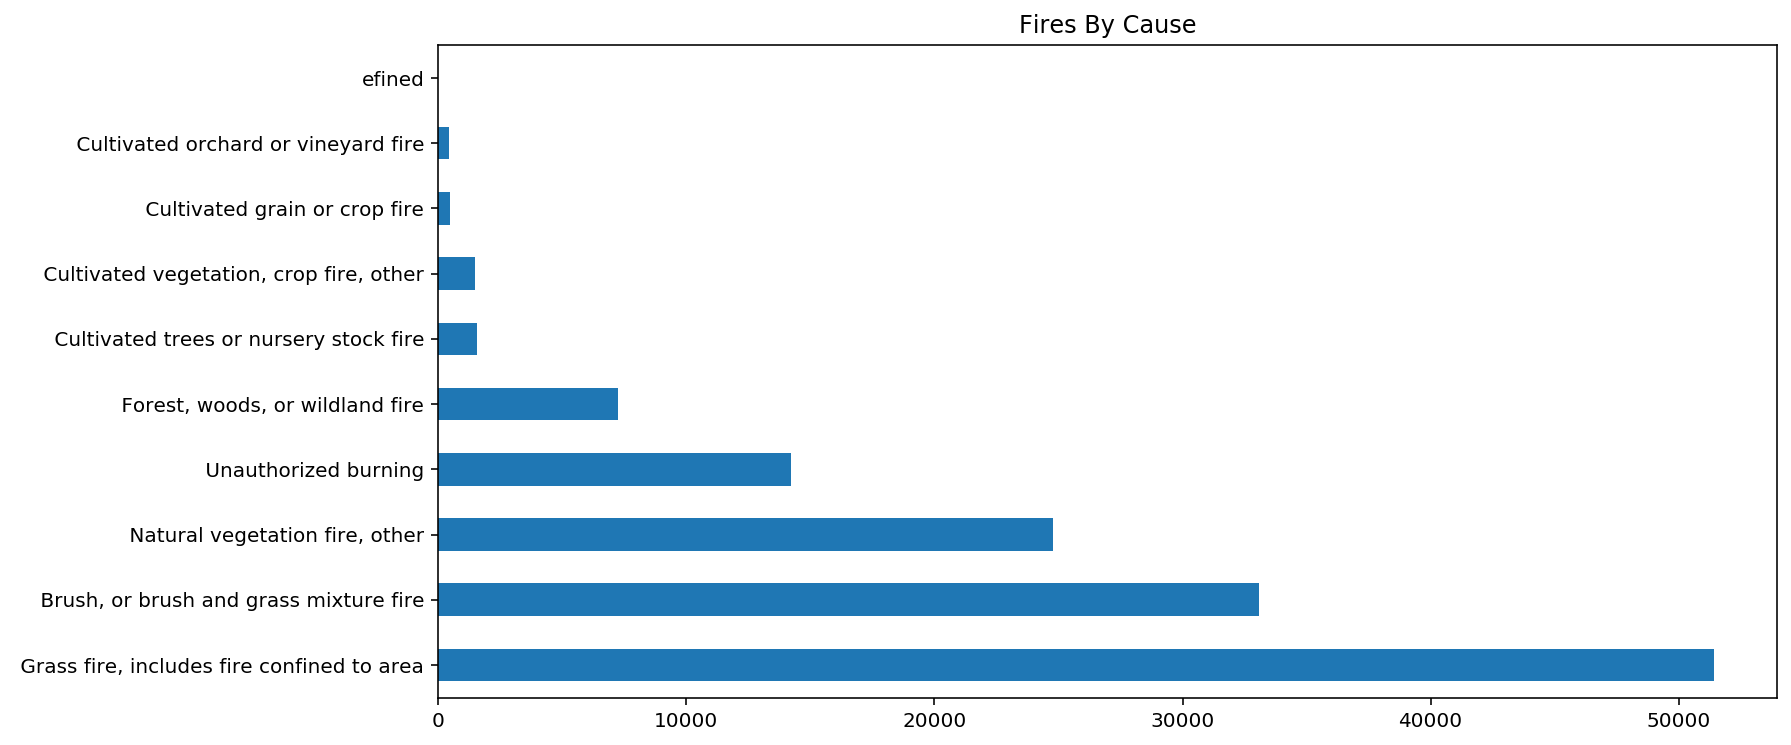

In [36]:
plt.figure(figsize=(12,6))

df['type_description'].value_counts().plot(kind='barh');
plt.title('Fires By Cause')
plt.show()

Setting the index on this dataframe to the timeseries. I'll pick this up in a different notebook.

In [57]:
df_timeseries = df.set_index('start_date')

In [60]:
df_timeseries.to_csv('./Cal_Fire/df_timeseries')

In [71]:
df.groupby((df["start_date"].year) ).count()

AttributeError: 'Series' object has no attribute 'year'

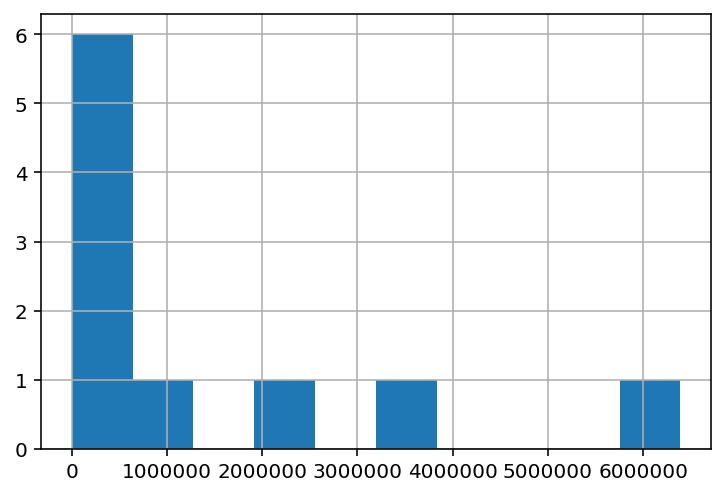

In [69]:
df.groupby('type_description')['total_acres_burned'].sum().hist();

In [171]:

# output to static HTML file
output_file("line.html")

p = figure(plot_width=400, plot_height=400)

# add a circle renderer with a size, color, and alpha
p.circle(df['nfirs_incidenttype_code_and_description'], df['nfirs_incidenttype_code_and_description'], size=20, color="navy", alpha=0.5)

# show the results
show(p)

In [170]:
df['nfirs_incidenttype_code_and_description'].count()

134678

In [221]:
df[df['incident_name'] == "PARK"]

,fire_department_identification_number_fdid,fire_department_name,incident_number,exposure_number,nfirs_incidenttype_code_and_description,incident_name,year,start_date,containment_date,county,...,zip,cross_streets_or_directions_or_national_grid,latitude,longitude,total_injuries,total_fatalities,estimated_property_or_contents_loss,total_acres_burned,cause,burn_duration
1367,31010,AUBURN VFD,6001,0,"143 Grass fire, includes fire confined to area",PARK,2013,2013-03-13,2013-03-13 00:00:00,Placer,...,95603,"300 BLK RACETRACK ST, 199 BLK",38.889850,-121.080050,0,0,0,0.00,MISCELLANEOUS,00:00:00
3702,9555,CDF-EL DORADO,9939,0,"141 Forest, woods, or wildland fire",PARK,2013,2013-05-03,2013-05-03 13:25:00,El Dorado,...,95726,"4300 BLK LAKERIDGE DR, 7221 BL",38.739917,-120.565767,0,0,0,0.10,DEBRIS BURNING,13:25:00
4482,9555,CDF-EL DORADO,10832,0,"142 Brush, or brush and grass mixture fire",PARK,2013,2013-05-13,2013-05-13 13:05:00,El Dorado,...,95726,Park Creek Rd,38.731667,-120.484883,0,0,0,0.10,MISCELLANEOUS,13:05:00
6304,37555,CDF-SAN DIEGO,11669,0,"142 Brush, or brush and grass mixture fire",PARK,2013,2013-06-04,2013-06-04 12:30:00,San Diego,...,91906,"PRIVATE RD, 2500 BLK LAKE SHOR",32.689717,-116.524967,0,0,0,0.25,MISCELLANEOUS,12:30:00
6689,10032,FRESNO COUNTY FPD,7526,0,"143 Grass fire, includes fire confined to area",PARK,2013,2013-06-09,2013-06-09 14:31:00,Fresno,...,93210,GALE,36.099783,-120.418500,0,0,0,1.00,ELECTRICAL POWER,14:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123403,33085,SAN JACINTO FD,0086633,0,"142 Brush, or brush and grass mixture fire",PARK,2019,2019-07-07,2019-07-07 18:00:00,Riverside,...,92583,Park,33.763400,-116.948833,0,0,0,1.00,Playing with Fire,18:00:00
124607,4555,CDF-BUTTE,0008525,0,"143 Grass fire, includes fire confined to area",PARK,2019,2019-07-19,2019-07-19 17:30:00,Butte,...,95966,Btwn: 1299 BLK DUNSTONE DR and,39.627333,-121.787333,0,0,0,13.60,Undetermined,17:30:00
126112,9555,CDF-EL DORADO,0023567,0,"143 Grass fire, includes fire confined to area",PARK,2019,2019-08-04,2019-08-04 05:10:39,El Dorado,...,95762,Btwn: DEAD-END and 312 BLK AR,38.660500,-121.081867,0,0,0,0.00,Miscellaneous,05:10:39
131308,33070,PERRIS FD,0131228,0,"143 Grass fire, includes fire confined to area",PARK,2019,2019-10-12,2019-10-12 15:35:00,Riverside,...,92570,Btwn: 500 BLK W 4TH ST and 500,33.775000,-117.236667,0,0,0,1.30,Arson,15:35:00


In [117]:
df.burn_duration.dtype

dtype('float64')

In [118]:
df = df.loc[df.burn_duration>0]

In [119]:
df['burn_duration'].value_counts()

1080.000000    331
1020.000000    301
960.000000     276
900.000000     267
930.000000     215
              ... 
1207.166667      1
508.500000       1
30.366667        1
1410.016667      1
867.233333       1
Name: burn_duration, Length: 6044, dtype: int64

In [121]:
1020/60

17.0

In [122]:
df.shape

(45605, 1405)